## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk #to add words to stop words
import re
import string

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set seed
import random
random.seed(10)

#word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#topic modeling
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
#import file 
#congress_tweets = pd.read_csv("C://Users/mjkeh/CSS_Project5_Team3_Spring2022/data/116th Congressional Tweets and Demographics.csv")
congress_tweets = pd.read_csv("/Users/neldeeb/Desktop/Spring 2022/Comp Social Sci - 273/Projects/Computational Social Science Project 5/data/116th Congressional Tweets and Demographics.csv")
#congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [3]:
#check the size of the dataset
print("Shape of current df:", congress_tweets.shape)


Shape of current df: (946791, 16)


In [4]:
#subset the data
## fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(frac=0.01, random_state=0)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [5]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [6]:
#check the size of the new dataset
congress_tweets.shape

(9468, 16)

In [7]:
#text data
congress_tweets['text'].head(30)

0     All of #OH14 salutes you, Patrolman St. Clair!...
1     In Case You Missed It: Bipartisanship works – ...
2     Wishing a happy #Passover to all those celebra...
3     RT @WhiteHouse President @realDonaldTrump just...
4     I just sent a letter demanding the Administrat...
5     The President’s attacks on Rep. @Ilhan are dis...
6     RT @HouseGOP It's time to get serious about ho...
7     RT @wdtnews With five confirmed COVID-19 cases...
8     RT @SVLeadershipGrp "We can only be game chang...
9     “This nation will remain the land of the free ...
10    This is true and we will address this soon.......
11    Preach. 🙏🏾 https://twitter.com/shondarhimes/st...
12    Among public institutions, @ASU is third in th...
13    There is no way Eric Swalwell should continue ...
14    NOW: on the air with @SethLeibsohn to talk abo...
15    Whistleblower reportedly worked with Joe Biden...
16    RT @MontclairNJGov Essex County Satellite Test...
17    I know there has been a lot of concern abo

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
#Remove emojis - FOUND ON GITHUB

def rem_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            u"\u200d"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_emoji)

In [9]:
#Remove line breaks 
#NE: added this to deal with issue later 
def rem_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#Passing function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_lbreaks)

In [10]:
#Remove urls - FOUND ON STACK OVERFLOW
def rem_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text' 
congress_tweets['text'] = congress_tweets['text'].apply(rem_urls)

In [11]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt") #NE: to get rid of retweets 
    nlp.Defaults.stop_words.add("RT") #MJ: to get rid of rt in capital letters
    nlp.Defaults.stop_words.add("qt") #NE: to get rid of quote tweets 
    nlp.Defaults.stop_words.add("QT") #MJ: to get rid of qt in capital letters
    nlp.Defaults.stop_words.add("amp") #NE: to get rid of accelerated mobile pages
    nlp.Defaults.stop_words.add("AMP") #MJ: to get rid of accelerated mobile pages in capital letters
   # nlp.Defaults.stop_words.add("need") #NE: to get rid of the word "need" big on all wordclouds (thoughts?) 
##MJ : it may mean something, so I removed "need" from stop words
#NE: I actually think we should remove the words that are big across all wordclouds because they have no meaning 
   # nlp.Defaults.stop_words.add("today") #NE: to get rid of the word "today" big on all wordclouds (thoughts?) 
    ##MJ : it may mean something, so I removed "today" from stop words    
#NE: I actually think we should remove the words that are big across all wordclouds because they have no meaning 
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    #create tokens
    spacy_words = [token.text.lower() for token in doc] #NE: if we want to make the text all lower case 
    #EG: why not do this at the beginning so that we don't have to have take care of "rt" and "RT" individually?
    #NE: beginning where? do we need to do RT caps if this is all in the same function? 

    
    spacy_words = [word for word in spacy_words if not word.startswith('http')] #MJ: this also removes some of the urls?
    #EG: is this necessary? I checked with this code and found no additional tweets that contained substring "http"
    # congress_tweets.loc[congress_tweets['text'].str.contains("http",case=False)]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [12]:
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
#EG: we had done this already. Is there a reason why we're repeating this step?
#NE: shouldn't we do it again after pre-processing?

In [13]:
#use the map() function to apply our rem_punc_stop function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text' (ie, each tweet)
#NE: I AM NOT SURE IF WE NEED TO DO THIS FOR URLS AND EMOJI AS WELL OR IF IT PASSED ABOVE ##MJ- I removed these since they cause errors
#congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_urls(x))
#congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_emoji(x))
congress_tweets.head()

#EG: this puntuation did not delete "–". Do we care?
#NE: I don't know...

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [14]:
#Remove tweets with no words 
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [15]:
#Remove quote around tokens
congress_tweets['tokens']=congress_tweets['tokens'].replace(r"'"," ", regex=True)

In [16]:
congress_tweets['tokens'][0] # text string -> tokens in list form

#EG: do we want to get rid of spaces?
#NE: YES! I couldn't figure out how!

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 '  ',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 ' ',
 'rooseveltlfox8']

In [17]:
def rem_blanks(token_list): 
    new_list = [x.strip() for x in token_list]  #remove leading and trailing spaces from each token in list
    remove_empty = [element for element in new_list if element.strip()] # delete empty elements 
    return(remove_empty) # return list of non empty tokens 
    
congress_tweets['cleantokens'] = congress_tweets['tokens'].apply(rem_blanks)

In [22]:
congress_tweets['cleantokens'][0] # text string -> tokens in list form

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 'rooseveltlfox8']

In [23]:
#get rid of tokens that are brackets 
congress_tweets['length_tokens']=congress_tweets['cleantokens'].str.len()
congress_tweets=pd.DataFrame(congress_tweets[congress_tweets['length_tokens']>2])
#EG: should we rename the new df congress_tweets to replace the original one? 
#NE: renamed it, so we don't need to use it moving forward, right?

In [24]:
#Length of smallest tweet
congress_tweets['cleantokens'].str.len().min()

3

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

## EDA 1. WordClouds

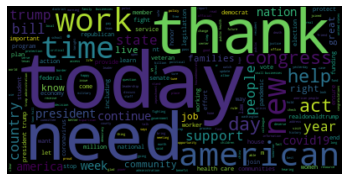

In [25]:
#WordCloud(ALL)

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['cleantokens'].map(lambda text: ' '.join(text))) #join every item with space
#EG: why are we using the congress_tweets df and not congress_tweets_notempty

# feed string to wordcloud
wordcloud = WordCloud().generate(text) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [26]:
#political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
print("Shape of current df:", congress_tweets_R.shape)
congress_tweets_R.head()

Shape of current df: (3371, 19)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8...","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...","[way, eric, swalwell, continue, serve, house, ...",8


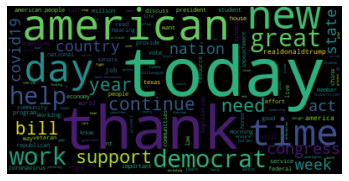

In [27]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['cleantokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [28]:
#political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
print("Shape of current df:", congress_tweets_D.shape)
congress_tweets_D.head()

Shape of current df: (5926, 19)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,...","[case, missed, bipartisanship, works, –, bill,...",10
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...","[svleadershipgrp, game, changers, accept, resp...",18


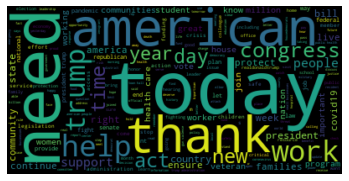

In [29]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['cleantokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [31]:
# EG: it looks like "today", "american", "need", "work", "day", "week", "year", "help", and "support" are (will be?) useless

In [32]:
#Legislator position- Senator

congress_tweets_sen = congress_tweets[congress_tweets["position"]=="Sen"]
print("Shape of current df:", congress_tweets_sen.shape)
congress_tweets_sen.head()

Shape of current df: (2228, 19)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens
12,1.105870e+18,SenatorSinema,2019-03-13T12:36:37-04:00,"Among public institutions, @ASU is third in th...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[public, institutions, asu, nation, student, f...","[public, institutions, asu, nation, student, f...",12
24,1.249040e+18,SenatorSinema,2020-04-11T14:19:58-04:00,"Arizonans: if you've lost your job, been furlo...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[arizonans, ve, lost, job, furloughed, hours, ...","[arizonans, ve, lost, job, furloughed, hours, ...",20
28,1.105590e+18,MartinHeinrich,2019-03-12T18:15:17-04:00,Proud that my bipartisan bill with @SenAlexand...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,Senate,Democrat,"319,667","385,234","415,335","335,788","[proud, bipartisan, bill, senalexander, signed...","[proud, bipartisan, bill, senalexander, signed...",23
34,1.105460e+18,PattyMurray,2019-03-12T09:12:00-04:00,ICYMI: The latest #TrumpBudget has massive tax...,Patty Murray,Sen,3-Jan-17,10/11/1950,F,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[icymi, latest, trumpbudget, massive, tax, bre...","[icymi, latest, trumpbudget, massive, tax, bre...",22
35,1.186770e+18,McConnellPress,2019-10-22T18:12:22-04:00,RT @ARCgov ARC Federal Co-Chairman Tim Thomas:...,Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[arcgov, arc, federal, cochairman, tim, thomas...","[arcgov, arc, federal, cochairman, tim, thomas...",24


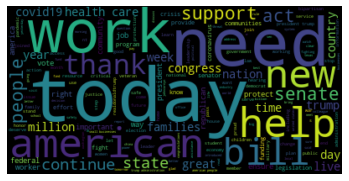

In [33]:
##WordCloud for Senators (NE ADDED)
# Convert list of tokens back to text string
text_sen = ' '.join(congress_tweets_sen['cleantokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_sen) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [34]:
#Legislator position- House of Representatives 

congress_tweets_hrep = congress_tweets[congress_tweets["position"]=="Rep"]
print("Shape of current df:", congress_tweets_hrep.shape)
congress_tweets_hrep.head()

Shape of current df: (7113, 19)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8...","[oh14, salutes, patrolman, st, clair, fox8news...",14
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,...","[case, missed, bipartisanship, works, –, bill,...",10
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...","[wishing, happy, passover, celebrating, seder,...",6
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...","[whitehouse, president, realdonaldtrump, signe...",12
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...","[sent, letter, demanding, administration, stop...",22


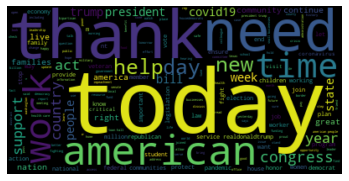

In [35]:
##WordCloud for House of Representatives (NE ADDED)
# Convert list of tokens back to text string
text_hrep = ' '.join(congress_tweets_hrep['cleantokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_hrep) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [36]:
#EG: yes, definitely many of the most frequent words will be useless in predicting party and chamber.
# maybe we should just get rid of the top 10/20 words, like we discussed in lab?
#NE: I like the idea of getting rid of the top 10 words 

## Wordcloud shows that the most frequently used words do not vary a lot by party(e.g., today, thank, american). However, it shows that the republicans use "great" and "new" more frequently, while democrats use "healthcare" and "communities" more frequently- which is expected.

## Wordcloud also shows that both Senates and Representatives use "today" and "need" a lot. But Senates use "work" more often while Representatives use "thank" more often.

## EDA 2. Topic modeling 

In [37]:
#create tf-idf matrix
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop) #creating an object : tf model

tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
dense_matrix = tfidf_matrix.todense() #remove all the columns where there are 0

In [38]:
tfidf_matrix

<9341x27865 sparse matrix of type '<class 'numpy.float64'>'
	with 183339 stored elements in Compressed Sparse Row format>

In [39]:
dense_matrix

matrix([[0.06269209, 0.12671228, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.06885947, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [40]:
#initialize model/ prespecify the parameter n => "5 topics"
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0) #random_state for reproducibility
lda = lda.fit(dense_matrix) # pass through our dense matrix

In [41]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [42]:
#prints out top words using different objects attached to our lda model
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
  today great american president trump people house need families covid19 work happy act new congress thank help    country

Topic #1:
  today americans great help new day thank state people health need covid19 “ ” time work public congress trump

Topic #2:
  today president trump health need people congress democrats covid19 help work census ” house care americans new    coronavirus

Topic #3:
  act today people senate house trump president american vote americans time bill help congress health democrats impeachment need support

Topic #4:
  health — today act care thank work bill new covid19 need workers federal help support congress    communities women



In [43]:
#get the topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.04207401, 0.04188601, 0.83177083, 0.0422521 , 0.04201705],
       [0.05067935, 0.79806634, 0.05036511, 0.05100687, 0.04988233],
       [0.06070095, 0.05993348, 0.76008932, 0.05945996, 0.0598163 ],
       ...,
       [0.02899995, 0.02907938, 0.02953356, 0.02917273, 0.88321439],
       [0.06427524, 0.0643817 , 0.74358749, 0.06403818, 0.06371739],
       [0.04926671, 0.80491712, 0.04872069, 0.04879261, 0.04830288]])

In [44]:
#merge back with original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics

,0,1,2,3,4,index,tweet_id,screen_name,datetime,text,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens
0,0.042074,0.041886,0.831771,0.042252,0.042017,0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",...,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8...","[oh14, salutes, patrolman, st, clair, fox8news...",14
1,0.050679,0.798066,0.050365,0.051007,0.049882,1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,...,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,...","[case, missed, bipartisanship, works, –, bill,...",10
2,0.060701,0.059933,0.760089,0.059460,0.059816,2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,...,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...","[wishing, happy, passover, celebrating, seder,...",6
3,0.046269,0.046882,0.813082,0.046941,0.046825,3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,...,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...","[whitehouse, president, realdonaldtrump, signe...",12
4,0.036532,0.036063,0.036493,0.036216,0.854696,4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,...,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...","[sent, letter, demanding, administration, stop...",22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,0.036480,0.853568,0.036437,0.037107,0.036408,9432,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,...,AR,2,Republican,"684,872","380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...","[greatest, strength, lies, love, repdebdingell...",31
9337,0.851278,0.036985,0.037613,0.037037,0.037086,9433,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",...,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...","[davidaxelrod, leader, sayyes, face, deadly, p...",22
9338,0.029000,0.029079,0.029534,0.029173,0.883214,9434,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,...,MS,Senate,Republican,"700,714","485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...","[tatereeves, chicago, mayor, says, mississippi...",45
9339,0.064275,0.064382,0.743587,0.064038,0.063717,9435,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,...,CT,5,Democrat,"673,215","897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]","[tomorrow, electionday, sure, voice, heard]",5


In [45]:
#check the average weight of each topic across "party" using groupby
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican     0.214791
Democrat       0.197326
Independent    0.130205
Name: 0, dtype: float64
party
Republican     0.189859
Democrat       0.174589
Independent    0.129449
Name: 1, dtype: float64
party
Independent    0.297253
Democrat       0.215123
Republican     0.210517
Name: 2, dtype: float64
party
Democrat       0.228275
Republican     0.215920
Independent    0.186194
Name: 3, dtype: float64
party
Independent    0.256899
Democrat       0.184686
Republican     0.168913
Name: 4, dtype: float64


In [46]:
#check the average weight of each topic across "position" using groupby
grouped2 = df_w_topics.groupby('position')
for i in range(0, 5):
    print(grouped2[i].mean().sort_values(ascending=False))

position
Rep    0.203579
Sen    0.202462
Name: 0, dtype: float64
position
Sen    0.192326
Rep    0.175991
Name: 1, dtype: float64
position
Rep    0.216441
Sen    0.205568
Name: 2, dtype: float64
position
Rep    0.227952
Sen    0.209783
Name: 3, dtype: float64
position
Sen    0.189862
Rep    0.176036
Name: 4, dtype: float64


## NE: I added a grouped by party too

## MJK All 10 topics do not seem to have a lot of separation between senators and representatives, but we will visualize Topic 0 and Topic 9 that show little more difference.
 

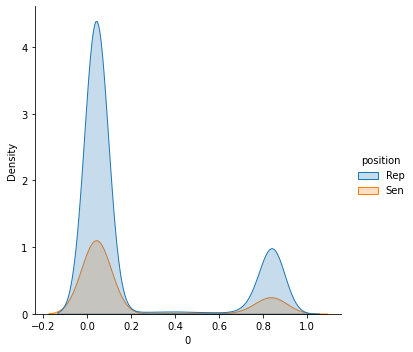

In [47]:
# Visualization- Topic 1 - for position
sns.displot(df_w_topics, x=df_w_topics[0], hue = "position", kind = 'kde', fill = 'true')
plt.show()

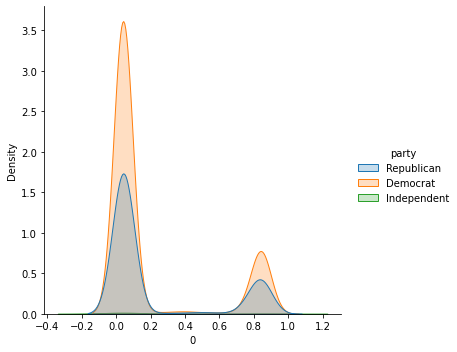

In [48]:
# Visualization- Topic 1 - for party 
sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
plt.show()

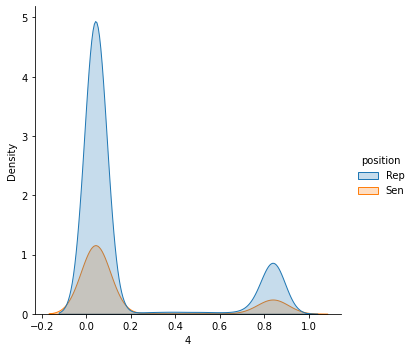

In [49]:
# Visualization- Topic 5 - for position
sns.displot(df_w_topics, x=df_w_topics[4], hue = "position", kind = 'kde', fill = 'true')
plt.show()

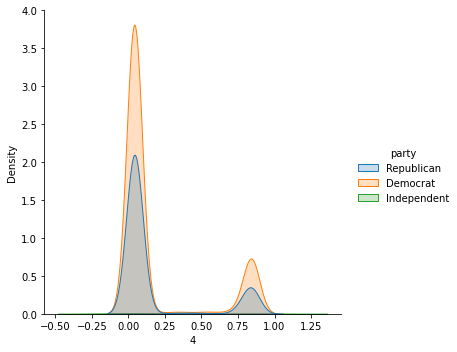

In [50]:
# Visualization- Topic 5 - for party 
sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## NE: I added visualizations for party too 

## MJK: The visualizations show that the topics would NOT be good candidates to pass to a supervised learning algorithm if we were interested in predicting the position(senate/representative).

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

In [51]:
congress_tweets['cleantokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens'] = congress_tweets['cleantokens'].map(lambda text: ' '.join(text))
#EG: why are we doing this again? it just adds more processing work to the program
#NE: the code below doesn't run without this step

#congress_tweets['tokens'].head()

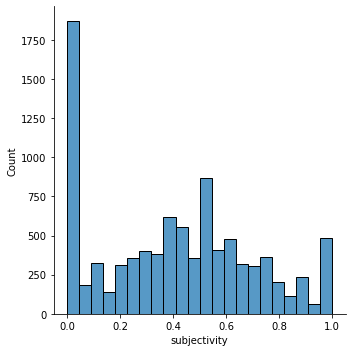

In [69]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

In [70]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens,subjectivity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",oh14 salutes patrolman st clair fox8news 5y...,"[oh14, salutes, patrolman, st, clair, , fox8...",14,0.0
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",case missed bipartisanship works – bill eradic...,"[case, missed, bipartisanship, works, –, bill,...",10,0.0
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869",wishing happy passover celebrating seder tonight,"[wishing, happy, passover, celebrating, seder,...",6,1.0
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",whitehouse president realdonaldtrump signed bi...,"[whitehouse, president, realdonaldtrump, signe...",12,0.0
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",sent letter demanding administration stop play...,"[sent, letter, demanding, administration, stop...",22,1.0


##   Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Although the overall distribution is normal, more tweets were factual information(subjectivity ==0) compared to opinions(subjectivity ==1).

## 2) Choose two legislators, one liberal and one conservative

In [71]:
# Republican: David Joyce
congress_tweets_R.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8...","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...","[way, eric, swalwell, continue, serve, house, ...",8


In [72]:
#congress_tweets_DavidJoyce = congress_tweets['text'][0]
#print(congress_tweets_DavidJoyce)

# EG: this only selects the very first tweet, which is Joyce's. Do we only want one tweet or all tweets by Joyce?
# if latter: congress_tweets[congress_tweets['name_wikipedia']=='David Joyce']
#NE: I agree it's meant to be per tweet not per word, moved your code below

In [73]:
congress_tweets_DavidJoyce = [congress_tweets["name_wikipedia"]=="David Joyce"]
print(congress_tweets_DavidJoyce)

[0        True
1       False
2       False
3       False
4       False
        ...  
9432    False
9433    False
9434    False
9435    False
9436    False
Name: name_wikipedia, Length: 9341, dtype: bool]


In [74]:
#sentiment analysis of one tweet 

congress_tweets_DavidJoyce = "All of #OH14 salutes you, Patrolman St. Clair! 👮‍♂️ https://twitter.com/fox8news/status/1182779635840495622 QT @fox8news 5-year-old battling cancer becomes Bainbridge police officer for the day http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ via @RooseveltLFOX8"
print("overall subjectivity score for David Joyce(Republican) is", TextBlob(congress_tweets_DavidJoyce).sentiment.subjectivity)
for word in congress_tweets_DavidJoyce.split():
    print(word, TextBlob(word).sentiment.subjectivity)

#EG: why not use "tokens" column rather than the original text? It's already cleaned up
#EG: also, do we want to get these values per word or per tweet?
#NE: I tried the code below but it didn't work 

overall subjectivity score for David Joyce(Republican) is 0.0
All 0.0
of 0.0
#OH14 0.0
salutes 0.0
you, 0.0
Patrolman 0.0
St. 0.0
Clair! 0.0
👮‍♂️ 0.0
https://twitter.com/fox8news/status/1182779635840495622 0.0
QT 0.0
@fox8news 0.0
5-year-old 0.0
battling 0.0
cancer 0.0
becomes 0.0
Bainbridge 0.0
police 0.0
officer 0.0
for 0.0
the 0.0
day 0.0
http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ 0.0
via 0.0
@RooseveltLFOX8 0.0


In [64]:
#congress_tweets_DavidJoyce['subjectivity'] = congress_tweets_DavidJoyce['cleantokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

## The overall subjectivity score for David Joyce(Republican) is 0.0

In [75]:
# Democrat: Josh Harder
congress_tweets_D.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,...","[case, missed, bipartisanship, works, –, bill,...",10
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...","[svleadershipgrp, game, changers, accept, resp...",18


In [76]:
congress_tweets_JoshHarder = congress_tweets['text'][1]
print(congress_tweets_JoshHarder)

In Case You Missed It: Bipartisanship works – and now my bill to eradicate swamp rats is becoming law!


In [77]:
congress_tweets_JoshHarder = "In Case You Missed It: Bipartisanship works – and now my bill to eradicate swamp rats is becoming law! https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/"
print("overall subjectivity score for Josh Harder(Democrat) is", TextBlob(congress_tweets_JoshHarder).sentiment.subjectivity)
for word in congress_tweets_JoshHarder.split():
    print(word, TextBlob(word).sentiment.subjectivity)

overall subjectivity score for Josh Harder(Democrat) is 0.8500000000000001
In 0.0
Case 0.0
You 0.0
Missed 0.0
It: 0.0
Bipartisanship 0.0
works 0.0
– 0.0
and 0.0
now 0.0
my 0.0
bill 0.0
to 0.0
eradicate 0.0
swamp 0.0
rats 0.0
is 0.0
becoming 0.8500000000000001
law! 0.0
https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/ 0.0


## The overall subjectivity score for Josh Harder(Democrat) is 0.85

## 3-1)  compare Democrats v. Republicans 

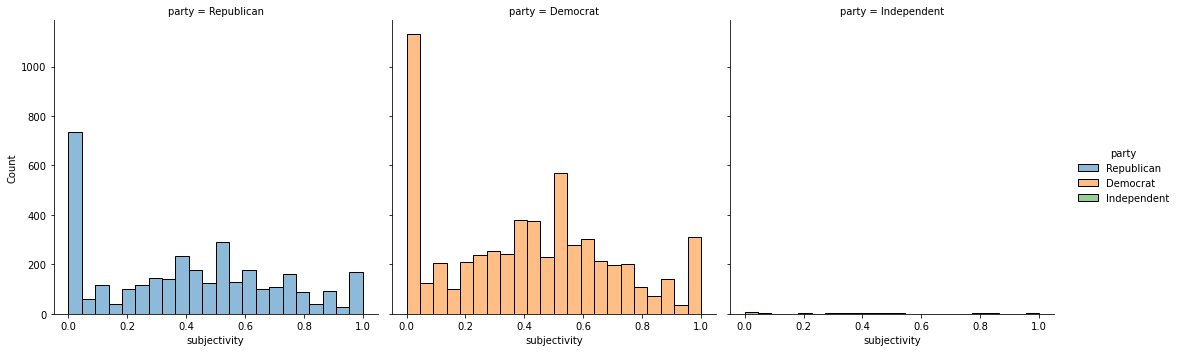

In [78]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

## Democrats tend to post more factual information(subjectivity ==0) than republicans

## 3-2) compare Senators v. Representatives 

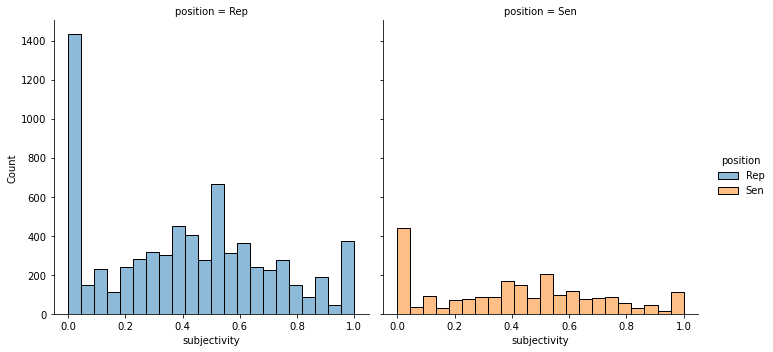

In [79]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

## Representatives tend to post more factual information(subjectivity ==0) than Senators

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [83]:
congress_tweets['cleantokens'] = congress_tweets['cleantokens'].map(lambda text: ' '.join(text)) #made into string
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [84]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'cleantokens', 'length_tokens',
       'subjectivity', 'polarity'],
      dtype='object')

In [85]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,cleantokens,length_tokens,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",oh14 salutes patrolman st clair fox8news 5y...,oh14 salutes patrolman st clair fox8news 5y...,14,0.0,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",case missed bipartisanship works – bill eradic...,case missed bipartisanship works – bill eradic...,10,0.0,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,Democrat,"943,169","1,677,928","1,677,844","971,869",wishing happy passover celebrating seder tonight,wishing happy passover celebrating seder tonight,6,1.0,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",whitehouse president realdonaldtrump signed bi...,whitehouse president realdonaldtrump signed bi...,12,0.0,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",sent letter demanding administration stop play...,sent letter demanding administration stop play...,22,1.0,-0.166667


### Engineered Text Features

In [86]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

In [87]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,polarity,subjectivity
0,0.042074,0.041886,0.831771,0.042252,0.042017,0.000000,0.0
1,0.050679,0.798066,0.050365,0.051007,0.049882,0.000000,0.0
2,0.060701,0.059933,0.760089,0.059460,0.059816,0.800000,1.0
3,0.046269,0.046882,0.813082,0.046941,0.046825,0.000000,0.0
4,0.036532,0.036063,0.036493,0.036216,0.854696,-0.166667,1.0


### Bag-of-words or Tf-idf

In [88]:
# Frequency Based featurization
X = congress_tweets['cleantokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

In [89]:
tfidf_df.head()

,,,,,,,,,,,...,🧔,🧙,🧡,🧬,🧵,🧹,🧼,🩺,🫂,🫐
0,0.000000,0.074574,0.134301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.122954,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.088294,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
#EG: I think we need to/want to get rid of all the "\n", which really just means linebreak in text.
# also, weren't emojis gone? Why are they back?
#NE: I got rid of line breaks in the pre-processing, I have no idea why the emojis are back. I even asked KQ about this and she didn't have an answer.

### Word Embedding - N STOPPED HERE 

In [91]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [92]:
#Using the function to re-tokenize
congress_tweets['cleantokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))

#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['cleantokens'], vector_size=100, window=3, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [ ]:
# Drop the tokens that aren't words in the model
model_words = []
i=0
for tweet in congress_tweets['cleantokens']:
    doc = [word for word in tweet if word in model.wv.index_to_key]
    if len(doc) < 1:
        model_words.append(i)
    i =i+1

print(model_words)

#Shape of congress_tweets_notempty
congress_tweets.shape


#Drop if the index is the same
congress_tweets_clean=congress_tweets.drop(congress_tweets.index[[model_words]])

congress_tweets_clean.shape

#NE: tried to get rid of the mising words but I get this error below

In [ ]:
congress_tweets_clean.head()

In [ ]:
len(congress_tweets_clean['cleantokens'][0])

In [ ]:
doc = [word for word in congress_tweets_clean['cleantokens'][0] if word in model.wv.index_to_key]
len(doc)

In [ ]:
doc [0:5]
#NE: not sure why I am still getting an empty word 

In [ ]:
#Now let's grab the first vector each token and take their mean:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

In [ ]:
#create this for every word - get all the means (FROM LAB)
#Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#get an average embedding for each doument 
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [ ]:
# Initialize an array for the size of the corpus
#each word is represented by 100 element list, so then it averages the first element for each word across all the words
empty_list_embeddings_means = []
for doc in congress_tweets_clean['cleantokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

##NE: I keep getting an error that says "NEED AT LEAST ONE ARRAY TO CONCATENATE" even though I got rid of missing words

In [ ]:
doc_average_embeddings

In [ ]:
#AVE EMBEDDINGS FOR EACH DOC 
doc_average_embeddings.shape

In [ ]:
#create dataframe
word2vec_features_df = pd.DataFrame(doc_average_embeddings) 

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**